In [1]:
import torch

from controllable_nca.image.emoji_dataset import EmojiDataset

In [2]:
dataset = EmojiDataset()

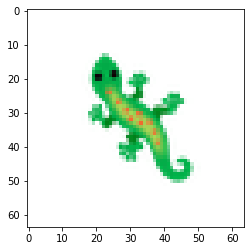

In [3]:
dataset.visualize(0)

### Import NCA

In [4]:
from controllable_nca.image.nca import ControllableImageNCA

In [5]:
nca =  ControllableImageNCA(target_shape=dataset.target_size(), living_channel_dim=3)

### Put in Cuda

In [6]:
device = torch.device('cuda')
dataset.to(device)
nca = nca.to(device)

### Trainer

In [7]:
from controllable_nca.image.trainer import ControllableNCAImageTrainer

In [8]:
trainer = ControllableNCAImageTrainer(nca, dataset, nca_steps=[48, 96], lr=1e-3, num_damaged=0, damage_radius=3, device=device, pool_size=1024)

Writing to tensorboard_logs/2022-02-08 15:02:19.127462


In [10]:
trainer.train(batch_size=4, epochs=50000)

  0%|                    | 0/50000 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.82 GiB total capacity; 1.36 GiB already allocated; 79.06 MiB free; 1.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF